<center><h1> KPMG Machine Learning Modelling Part <center><h1>

## Load Libraries for Cleaning and Modelling

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Imputing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modelling Preparation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder


from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

from sklearn.feature_selection import SelectKBest

# Supervised
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import (RandomForestClassifier, 
                              GradientBoostingClassifier,
                              AdaBoostClassifier,
                              BaggingClassifier)

import xgboost as xgb
from xgboost import XGBClassifier

import shap
shap.initjs()

# Metrics 
from sklearn.metrics import *

In [2]:
df = pd.read_excel('../../../Features_tagging_v3-2nd_line_class1.xlsx', sheet_name = 'features_v7', header = 1)

# df = pd.read_excel('./tagged_round_one.xlsx', sheet_name = 'features_v7', header = 1)

In [3]:
df.shape

(41910, 35)

#### Missing data analysis

* `line_height` is completely missing 
* `LS` has some missing values: This means that these lines do not have any LS; hence, we'll encode these to 0. 
* The rest of the missing columns are those that we made ourselves to tag the feature. We will be dropping them. 

In [4]:
df.isna().sum() 

text                         0
document                     0
Name                     28755
new_10_doc               39099
Section_Id_Document      41013
Section_ID               41011
Paragraph                40676
Comment                  39717
Class                    31356
df_idx                       0
class                        0
style                        0
id                           0
font-size                    0
vertical-align               0
color                        0
font-family                  0
font-weight                  0
font-style                   0
position                     0
left                         0
top                          0
document_id                  0
page                         0
line-height              41906
Num_Words                    0
String_Length                0
Leading_Char_Upper           0
Leading_Numeral              0
Ends_In_Period               0
Leading_Number_Period        0
Leading_Char_Period          0
Roman_Pe

#### Get document count

In [5]:
num_docs = len(df.groupby('document').count()['text'].rename('Count'))
num_docs

119

#### Drop rows which are not labelled

In [6]:
df = df[df['Class'].isna()==False]

#### See how many documents are done and percentage

In [7]:
num_docs_done = len(df.groupby('document').count()['text'].rename('Count'))

In [8]:
num_docs_done / num_docs

0.3445378151260504

### Extract `first 3 words`,` 5 words`, `first word`, `last word`

In [9]:
df.sample(2)

,text,document,Name,new_10_doc,Section_Id_Document,Section_ID,Paragraph,Comment,Class,df_idx,...,Num_Words,String_Length,Leading_Char_Upper,Leading_Numeral,Ends_In_Period,Leading_Number_Period,Leading_Char_Period,Roman_Period,Left_Px,LS
41735,organizations to collaborate with others to in...,html_files/CMS_2014_0115_9664.pdf,Minsu,NaN,NaN,NaN,NaN,NaN,0.0,28148,...,13,83,0,0,0,0,0,0,89,14.0
5526,"rule once finalized, will be able to avail the...",html_files/CMS_2014_0115_13182.pdf,Liliana,NaN,NaN,NaN,NaN,NaN,0.0,6172,...,16,96,0,0,0,0,0,0,72,14.0


In [10]:
def find_ngrams(input_list, n):
    return list(zip(*[input_list[i:] for i in range(n)]))

In [11]:
### Convert the text column data type to string

import re

df['text'] = df['text'].apply(str)

### Three gram

df['3_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 3))
#df['new_col'] = df.triigrams.apply(lambda x: x[0:1])
df['first_3_words'] = df["3_grams"].str[0]
df['first_3_words'] = df['first_3_words'].apply(str)
df['first_3_words'] = df['first_3_words'].str.replace(r'[^\w\s]+', '')

### Remove stop words from first 3 wodrds

# df['first_3_words'] = df['first_3_words'].apply(lambda x: [item for item in x.split(" ") if item not in stopwords])


### Five gram

df['5_grams'] = df['text'].map(lambda x: find_ngrams(x.split(" "), 5))
df['first_5_words'] = df['5_grams'].str[0]
df['first_5_words'] = df['first_5_words'].apply(str)
df['first_5_words'] = df['first_5_words'].str.replace(r'[^\w\s]+', '')


### I will drop 3-gram and 5_gram columns and keep only fist three words and first five words columns

df = df.drop(['3_grams', '5_grams'], axis = 1)


In [12]:
### Extract first and last word

df["First_Word"] = df["text"].apply(lambda x: x.split()[0:1])
df["First_Word"] = df["First_Word"].apply(str)
df["First_Word"] = df["First_Word"].str.replace(r'[^\w\s]+', '')

df["Last_Word"] = df["text"].apply(lambda x: x.split()[-1:])
df["Last_Word"] = df["Last_Word"].apply(str)
df["Last_Word"] = df["Last_Word"].str.replace(r'[^\w\s]+', '')

In [13]:
df.to_csv('../../../featuresV9.csv')

## Separate Test Set 

In [14]:
df_test = df[df['new_10_doc']==1]

In [15]:
df = df[df['new_10_doc'].isna()] # filter all missing 
df.drop(['new_10_doc'], axis=1, inplace=True) # drop column

## Data Cleaning

1. Drop irrelavant columns
2. Convert columns kept to right types 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 38 columns):
text                     7743 non-null object
document                 7743 non-null object
Name                     7743 non-null object
Section_Id_Document      897 non-null float64
Section_ID               899 non-null float64
Paragraph                1234 non-null object
Comment                  1165 non-null object
Class                    7743 non-null float64
df_idx                   7743 non-null int64
class                    7743 non-null object
style                    7743 non-null object
id                       7743 non-null object
font-size                7743 non-null object
vertical-align           7743 non-null object
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null object
font-style               7743 non-null object
position                 7743 non-null object
left              

### 1. Drop Irrelavant Columns 
* Drop text since we don't really need it and are using derived features from it 
* Drop columns that we created ourselves for tagging:
`Name`, `section Id document`, `document id`, `section id`, `Comment`, `Paragraph` are not useful since we created them for labelling or target
* `df_idx` is the same thing as document_id and document 
* We keep `document` : we will cat encdode it later 
* Remove `class` (lowercase) since it only has one value
* Drop `position` since it only has one value
* `line height` has nothing in it ... only **nans** 
* Remove `string length` since it's correlated with numwords
* Remove `Left_Px` since it's the same thing as `left` which I clean in the next section
* Remove `style` since it's the same thing as `font+vertical+align+color` which I clean in the next section
* Remove `vertical-align` since it's the same value which is `baseline`

In [17]:
df = df.drop(['text', 'Name', 'Section_Id_Document', 'document_id',
             'Section_ID', 'Comment', 'Paragraph', 'df_idx' , 'class', 'position',
              'page', 'line-height', 'String_Length', 'Left_Px','style','vertical-align'], axis = 1)

Columns that I may remove later:
- `page`: Not sure if it's relevant at all
- `color`: Need to clean it but may not give any feature importance


### 2. Clean columns:  `font_weight`,`font_style`,`fontsize`, `left` and `top`: 

- Change font_weight and font_size to binary
- Remove px and 
- Convert to right data typ

In [18]:
df['font-weight'] = df['font-weight'].map({'bold': 1, 'normal': 0})
df['font-style'] = df['font-style'].map({'italic': 1, 'normal': 0})

df['font-size'] = df['font-size'].str.replace('px', '')
df['font-size'] = pd.to_numeric(df['font-size'])

df['left'] = df['left'].str.replace('px', '')
df['left'] = pd.to_numeric(df['left'])

df['top'] = df['top'].str.replace('px', '')
df['top'] = pd.to_numeric(df['top'])

#### Chage the data type from `int` to `float`

In [19]:
# 'Start_conclusion','Start_Re','Start_Attention'

cols = ['font-weight', 'font-style', 'left', 'top','Num_Words','Leading_Char_Upper','Leading_Numeral','Ends_In_Period','Leading_Number_Period','Leading_Char_Period','Roman_Period']
for col in cols:
    df[col] = df[col].apply(lambda x: float(x))

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 22 columns):
document                 7743 non-null object
Class                    7743 non-null float64
id                       7743 non-null object
font-size                7743 non-null int64
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null float64
font-style               7743 non-null float64
left                     7743 non-null float64
top                      7743 non-null float64
Num_Words                7743 non-null float64
Leading_Char_Upper       7743 non-null float64
Leading_Numeral          7743 non-null float64
Ends_In_Period           7743 non-null float64
Leading_Number_Period    7743 non-null float64
Leading_Char_Period      7743 non-null float64
Roman_Period             7743 non-null float64
LS                       7527 non-null float64
first_3_words            7743 non-null object
first_

In [21]:
df.to_csv('../../../featuresV10.csv')

#### Impute Missing Column: LS


In [22]:
df['LS'] = df['LS'].fillna(0)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 22 columns):
document                 7743 non-null object
Class                    7743 non-null float64
id                       7743 non-null object
font-size                7743 non-null int64
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null float64
font-style               7743 non-null float64
left                     7743 non-null float64
top                      7743 non-null float64
Num_Words                7743 non-null float64
Leading_Char_Upper       7743 non-null float64
Leading_Numeral          7743 non-null float64
Ends_In_Period           7743 non-null float64
Leading_Number_Period    7743 non-null float64
Leading_Char_Period      7743 non-null float64
Roman_Period             7743 non-null float64
LS                       7743 non-null float64
first_3_words            7743 non-null object
first_

## Modelling
#### Part I: Data Cleaning and Preparation
1. Separate Target and Data
2. Split into Test and Train
3. Clean Numeric Features 
4. Clean Categorical Features
4. Try NLP Techniques
6. Combine Data Frames

#### Part II: Models
1. Logistic Regression
2. Random Forest
4. Playing with Evaluation Metrics
5. Boosting: AdaBoost and Gradient Boosting
6. Boosting: XGBoost

#### Part III: Pipeline and Tune
1. Parameter Tuning on the Best Model with Pipeline 
2. Change Thresholds
3. Evaluate on Test Set

### Part 1: Prepare

#### 1. Separate Target and Features 

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 22 columns):
document                 7743 non-null object
Class                    7743 non-null float64
id                       7743 non-null object
font-size                7743 non-null int64
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null float64
font-style               7743 non-null float64
left                     7743 non-null float64
top                      7743 non-null float64
Num_Words                7743 non-null float64
Leading_Char_Upper       7743 non-null float64
Leading_Numeral          7743 non-null float64
Ends_In_Period           7743 non-null float64
Leading_Number_Period    7743 non-null float64
Leading_Char_Period      7743 non-null float64
Roman_Period             7743 non-null float64
LS                       7743 non-null float64
first_3_words            7743 non-null object
first_

In [25]:
df.shape

(7743, 22)

In [26]:
X = df.drop(['Class'], axis = 1)

y = df['Class']

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7743 entries, 0 to 41909
Data columns (total 21 columns):
document                 7743 non-null object
id                       7743 non-null object
font-size                7743 non-null int64
color                    7743 non-null object
font-family              7743 non-null object
font-weight              7743 non-null float64
font-style               7743 non-null float64
left                     7743 non-null float64
top                      7743 non-null float64
Num_Words                7743 non-null float64
Leading_Char_Upper       7743 non-null float64
Leading_Numeral          7743 non-null float64
Ends_In_Period           7743 non-null float64
Leading_Number_Period    7743 non-null float64
Leading_Char_Period      7743 non-null float64
Roman_Period             7743 non-null float64
LS                       7743 non-null float64
first_3_words            7743 non-null object
first_5_words            7743 non-null object
First_W

In [28]:
X.shape

(7743, 21)

#### Check out imbalance

In [29]:
imbalance = (len(y[y == 1]) / len(y)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 2.52%


0.0    7548
1.0     195
Name: Class, dtype: int64

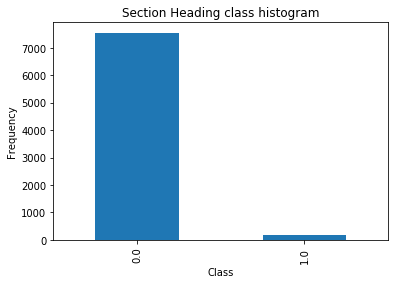

In [30]:
pd.value_counts(y).plot.bar()
plt.title('Section Heading class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
df['Class'].value_counts()

#### 2. Train Test Split

In [31]:
# 30% will be selected for testing data randomly
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.30,
                                                    shuffle = True,
                                                    random_state = 9834) 

In [32]:
imbalance = (len(y_train[y_train == 1]) / len(y)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 1.85%


In [33]:
imbalance = (len(y_test[y_test == 1]) / len(y)) * 100
print('Class Imblance: {:.2f}%'.format(imbalance))

Class Imblance: 0.67%


## Part III: Pipeline and Tune
* For this stage, we will use the best model

### Parameter Tuning on the Best Models with Pipeline

#### 1.1 Create the Preprocessing Pipeline

#### Categorical Features

In [34]:
cat_features = list(X.select_dtypes(include="object"))
cat_features.remove('First_Word')
cat_features.remove('Last_Word')
cat_features.remove('first_3_words')
cat_features.remove('first_5_words')
cat_features = cat_features

In [35]:
cat_features

['document', 'id', 'color', 'font-family']

#### Text Features

In [36]:
text_features = list(X.select_dtypes(include="object"))
text_features.remove('document')
text_features.remove('color')
text_features.remove('font-family')
text_features.remove('id')
text_features = text_features

In [37]:
text_features

['first_3_words', 'first_5_words', 'First_Word', 'Last_Word']

In [38]:
first_1 = [text_features[2], text_features[-1]]
first_3 = [text_features[0], text_features[-1]]
first_5 = [text_features[1], text_features[-1]]

In [39]:
first_3_only = text_features[0]
first_1_only = text_features[2]
first_5_only = text_features[1]
last_1_only =  text_features[-1]

#### Numeric Features: We can just borrow from the separations I had made above

In [40]:
list(X.select_dtypes(exclude="object"))

['font-size',
 'font-weight',
 'font-style',
 'left',
 'top',
 'Num_Words',
 'Leading_Char_Upper',
 'Leading_Numeral',
 'Ends_In_Period',
 'Leading_Number_Period',
 'Leading_Char_Period',
 'Roman_Period',
 'LS']

In [41]:
binary_features = ['font-weight', 'font-style', 'Leading_Char_Upper',
                'Leading_Numeral', 'Ends_In_Period', 'Leading_Number_Period',
                'Leading_Char_Period', 'Roman_Period']

In [42]:
continuous_features = ['font-size', 'left', 'top', 'Num_Words', 'LS']

#### Chain up Transformations or Custom Transformer

In [43]:
from sklearn.decomposition import PCA

continuous_transformer = Pipeline(steps=[('scale', StandardScaler())])

binary_transformer = Pipeline(steps=[('select', SelectKBest(k=8))])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

text_transformer_first = Pipeline([('count_vect_first', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
                             ('tfidf_first', TfidfTransformer())
                             ])

text_transformer_last = Pipeline([('count_vect_last', CountVectorizer()), 
                             ('tfidf_last', TfidfTransformer())
                             ])

In [44]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, continuous_features),
        ('binary', binary_transformer, binary_features),
        ('cat', categorical_transformer,cat_features),
        ('text_first', text_transformer_first, first_3_only),
        ('text_last', text_transformer_last, last_1_only)])

In [45]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [46]:
sm = SMOTE(random_state=42)

In [47]:
final_pipeline_rf = Pipeline([('preprocessor', preprocessor), 
                     ('smote', sm),
                    ('classifier', RandomForestClassifier(class_weight =  'balanced', random_state=4242))])

### 1. Random Forst with GridSearch

In [48]:
param_grid = {'classifier__n_estimators':[70, 80, 90, 100],
               'classifier__max_depth':[50,60,70,80,90, None]}

cv = StratifiedKFold(n_splits=5)

In [49]:
grid_rf = GridSearchCV(final_pipeline_rf, param_grid, cv = cv, scoring = 'roc_auc')

grid_rf.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pr

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cont', Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['font-size', 'left', 'top', 'Num...='warn', n_jobs=None, oob_score=False,
            random_state=4242, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__n_estimators': [70, 80, 90, 100], 'classifier__max_depth': [50, 60, 70, 80, 90, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [50]:
print("Best Score %s" % grid_rf.best_score_)
print("Best Parameter %s" % grid_rf.best_params_)

Best Score 0.9856712022924802
Best Parameter {'classifier__max_depth': 60, 'classifier__n_estimators': 80}


#### Change Thresholds and Re-evaluate Models

In [51]:
pred_probs = grid_rf.predict_proba(X_train)[:, 1]

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


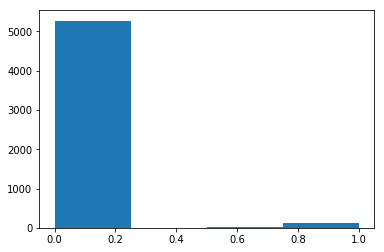

In [52]:
plt.hist(pred_probs, bins=4)
plt.show()

In [53]:
def metrics(y, pred):
    print("Accuracy score: {:.2f}".format(accuracy_score(y, pred)))
    print("F1 score: {:.2f}".format(f1_score(y, pred)))
    print("ROC AUC score: {:.2f}".format(roc_auc_score(y, pred)))

In [54]:
def confusion_metrics(y, pred):
    cm = confusion_matrix(y, pred)
    print("True Negatives:", cm[0][0])
    print("False Negatives:", cm[1][0])
    print("True Positives:", cm[1][1])
    print("False Positives:", cm[0][1])
    print(" ")
    print("Other Metrics:")
    print(" ")
    print("Precision %.2f" % (cm[1][1] / (cm[1][1] + cm[0][1])))
    print("Recall / True Positive Rate %.2f" % (cm[1][1] / (cm[1][1] + cm[1][0])))   
    print("True Negative Rate: %.2f" % (cm[0][0] / (cm[0][0] + cm[0][1])))   

In [55]:
for i in np.arange(0,0.5,0.05):
    y_pred = grid_rf.predict_proba(X_train)[:, 1] > i
    print("")
    print("Metrics")
    print("")
    print(confusion_metrics(y_train, y_pred))

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 4
False Negatives: 0
True Positives: 143
False Positives: 5273
 
Other Metrics:
 
Precision 0.03
Recall / True Positive Rate 1.00
True Negative Rate: 0.00
None

Metrics


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



True Negatives: 4863
False Negatives: 0
True Positives: 143
False Positives: 414
 
Other Metrics:
 
Precision 0.26
Recall / True Positive Rate 1.00
True Negative Rate: 0.92
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5197
False Negatives: 0
True Positives: 143
False Positives: 80
 
Other Metrics:
 
Precision 0.64
Recall / True Positive Rate 1.00
True Negative Rate: 0.98
None

Metrics



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 5251
False Negatives: 0
True Positives: 143
False Positives: 26
 
Other Metrics:
 
Precision 0.85
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None

Metrics

True Negatives: 5268
False Negatives: 0
True Positives: 143
False Positives: 9
 
Other Metrics:
 
Precision 0.94
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None

Metrics

True Negatives: 5271
False Negatives: 0
True Positives: 143
False Positives: 6
 
Other Metrics:
 
Precision 0.96
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5275
False Negatives: 0
True Positives: 143
False Positives: 2
 
Other Metrics:
 
Precision 0.99
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None

Metrics



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 5277
False Negatives: 0
True Positives: 143
False Positives: 0
 
Other Metrics:
 
Precision 1.00
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None

Metrics

True Negatives: 5277
False Negatives: 0
True Positives: 143
False Positives: 0
 
Other Metrics:
 
Precision 1.00
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None

Metrics

True Negatives: 5277
False Negatives: 0
True Positives: 143
False Positives: 0
 
Other Metrics:
 
Precision 1.00
Recall / True Positive Rate 1.00
True Negative Rate: 1.00
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Feature Importances

In [56]:
def plot_top_k_feature_importances_pipe(feature_names, coefs, k): 
    # sort 
    args = abs(coefs).argsort()[::-1][:k]    
    # get coefs 
    top_k_coefs = coefs[args]    
    # get column names
    colnames = feature_names[args]
    # plot 
    plt.barh(range(k), top_k_coefs, align='center') 
    plt.yticks(np.arange(k), colnames) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, k)
    plt.show()

In [107]:
def get_feature_names(grid):
    cont_cols = grid.best_estimator_.named_steps['preprocessor'].transformers_[0][2]
    bin_cols = grid.best_estimator_.named_steps['preprocessor'].transformers_[1][2]
    cat_cols = grid.best_estimator_.named_steps['preprocessor'].transformers_[2][1].named_steps['onehot'].get_feature_names()
    first_word = grid.best_estimator_.named_steps['preprocessor'].transformers_[3][1].named_steps['count_vect_first'].get_feature_names()
    last_word = grid.best_estimator_.named_steps['preprocessor'].transformers_[4][1].named_steps['count_vect_last'].get_feature_names()
    one_hot_feature_names = np.concatenate((cont_cols, bin_cols,cat_cols, first_word, last_word), axis = None)
    return one_hot_feature_names

In [108]:
one_hot_feature_names_rf = get_feature_names(grid_rf)

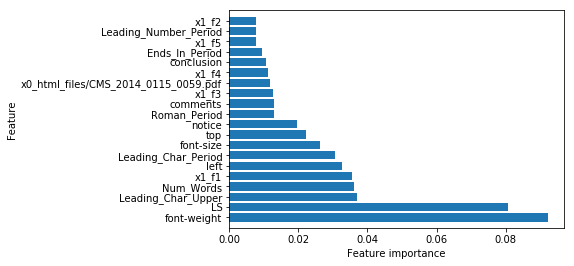

In [109]:
plot_top_k_feature_importances_pipe(one_hot_feature_names_rf, 
                                    grid_rf.best_estimator_.named_steps['classifier'].feature_importances_, 
                                    20)

#### Evaluate on Test Set

In [64]:
grid_rf.score(X_test,y_test)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.9903126376045794

In [65]:
y_pred = grid_rf.predict(X_test)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [66]:
metrics(y_test, y_pred)

Accuracy score: 0.98
F1 score: 0.41
ROC AUC score: 0.63


In [67]:
confusion_metrics(y_test, y_pred)

True Negatives: 2268
False Negatives: 38
True Positives: 14
False Positives: 3
 
Other Metrics:
 
Precision 0.82
Recall / True Positive Rate 0.27
True Negative Rate: 1.00


#### Change Thresholds and Re-Evaluate

In [68]:
pred_probs = grid_rf.predict_proba(X_test)[:, 1] 

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


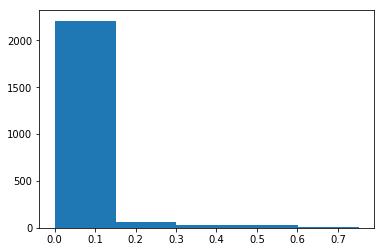

In [69]:
plt.hist(pred_probs, bins=5)
plt.show()

In [70]:
y_pred_probs = grid_rf.predict_proba(X_test)[:, 1]

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [71]:
def plot_pr_curve(y_test, y_pred_probs):
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs) 
    thresholds = np.append(thresholds, 1) 
    queue_rate = [] 
    for threshold in thresholds: 
        queue_rate.append((y_pred >= threshold).mean()) 
    plt.plot(thresholds, precision, color=sns.color_palette()[0]) 
    plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
    plt.plot(thresholds, queue_rate, color=sns.color_palette()[2]) 
    leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True) 
    leg.get_frame().set_edgecolor('k') 
    plt.xlabel('threshold') 
    plt.ylabel('%')

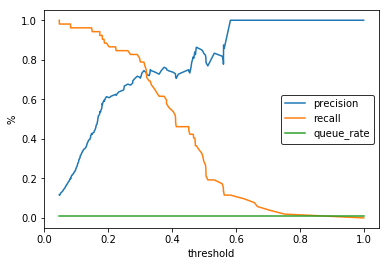

In [72]:
plot_pr_curve(y_test, y_pred_probs)

In [73]:
for i in np.arange(0,0.5,0.01):
    y_pred = grid_rf.predict_proba(X_test)[:, 1] > i
    print("")
    print("Metrics")
    print("Threshold =", i)
    print("")
    print(metrics(y_test, y_pred))
    print(confusion_metrics(y_test, y_pred))

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.0

Accuracy score: 0.02
F1 score: 0.04
ROC AUC score: 0.50
None
True Negatives: 0
False Negatives: 0
True Positives: 52
False Positives: 2271
 
Other Metrics:
 
Precision 0.02
Recall / True Positive Rate 1.00
True Negative Rate: 0.00
None

Metrics
Threshold = 0.01

Accuracy score: 0.46
F1 score: 0.08
ROC AUC score: 0.72
None
True Negatives: 1019
False Negatives: 0
True Positives: 52
False Positives: 1252
 
Other Metrics:
 
Precision 0.04
Recall / True Positive Rate 1.00
True Negative Rate: 0.45
None

Metrics
Threshold = 0.02

Accuracy score: 0.64
F1 score: 0.11
ROC AUC score: 0.81
None
True Negatives: 1426
False Negatives: 0
True Positives: 52
False Positives: 845
 
Other Metrics:
 
Precision 0.06
Recall / True Positive Rate 1.00
True Negative Rate: 0.63
None

Metrics
Threshold = 0.03

Accuracy score: 0.74
F1 score: 0.15
ROC AUC score: 0.87
None
True Negatives: 1660
False Negatives: 0
True Positives: 52
False Positives: 611
 
Other Metrics:
 
Precision 0.08
Recal

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.80
F1 score: 0.18
ROC AUC score: 0.90
None
True Negatives: 1798
False Negatives: 0
True Positives: 52
False Positives: 473
 
Other Metrics:
 
Precision 0.10
Recall / True Positive Rate 1.00
True Negative Rate: 0.79
None

Metrics
Threshold = 0.05

Accuracy score: 0.84
F1 score: 0.22
ROC AUC score: 0.91
None
True Negatives: 1907
False Negatives: 1
True Positives: 51
False Positives: 364
 
Other Metrics:
 
Precision 0.12
Recall / True Positive Rate 0.98
True Negative Rate: 0.84
None

Metrics
Threshold = 0.06



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.87
F1 score: 0.25
ROC AUC score: 0.92
None
True Negatives: 1966
False Negatives: 1
True Positives: 51
False Positives: 305
 
Other Metrics:
 
Precision 0.14
Recall / True Positive Rate 0.98
True Negative Rate: 0.87
None

Metrics
Threshold = 0.07

Accuracy score: 0.89
F1 score: 0.29
ROC AUC score: 0.94
None
True Negatives: 2020
False Negatives: 1
True Positives: 51
False Positives: 251
 
Other Metrics:
 
Precision 0.17
Recall / True Positive Rate 0.98
True Negative Rate: 0.89
None

Metrics
Threshold = 0.08

Accuracy score: 0.91
F1 score: 0.33
ROC AUC score: 0.94
None
True Negatives: 2062
False Negatives: 1
True Positives: 51
False Positives: 209
 
Other Metrics:
 
Precision 0.20
Recall / True Positive Rate 0.98
True Negative Rate: 0.91
None

Metrics
Threshold = 0.09

Accuracy score: 0.92
F1 score: 0.36
ROC AUC score: 0.94
None
True Negatives: 2097
False Negatives: 2
True Positives: 50
False Positives: 174
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


ROC AUC score: 0.95
None
True Negatives: 2125
False Negatives: 2
True Positives: 50
False Positives: 146
 
Other Metrics:
 
Precision 0.26
Recall / True Positive Rate 0.96
True Negative Rate: 0.94
None

Metrics
Threshold = 0.11

Accuracy score: 0.95
F1 score: 0.46
ROC AUC score: 0.96
None
True Negatives: 2155
False Negatives: 2
True Positives: 50
False Positives: 116
 
Other Metrics:
 
Precision 0.30
Recall / True Positive Rate 0.96
True Negative Rate: 0.95
None

Metrics
Threshold = 0.12

Accuracy score: 0.96
F1 score: 0.50
ROC AUC score: 0.96
None
True Negatives: 2173
False Negatives: 2
True Positives: 50
False Positives: 98
 
Other Metrics:
 
Precision 0.34
Recall / True Positive Rate 0.96
True Negative Rate: 0.96
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.13

Accuracy score: 0.96
F1 score: 0.52
ROC AUC score: 0.96
None
True Negatives: 2181
False Negatives: 2
True Positives: 50
False Positives: 90
 
Other Metrics:
 
Precision 0.36
Recall / True Positive Rate 0.96
True Negative Rate: 0.96
None

Metrics
Threshold = 0.14

Accuracy score: 0.97
F1 score: 0.56
ROC AUC score: 0.96
None
True Negatives: 2195
False Negatives: 2
True Positives: 50
False Positives: 76
 
Other Metrics:
 
Precision 0.40
Recall / True Positive Rate 0.96
True Negative Rate: 0.97
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.15

Accuracy score: 0.97
F1 score: 0.59
ROC AUC score: 0.96
None
True Negatives: 2206
False Negatives: 3
True Positives: 49
False Positives: 65
 
Other Metrics:
 
Precision 0.43
Recall / True Positive Rate 0.94
True Negative Rate: 0.97
None

Metrics
Threshold = 0.16

Accuracy score: 0.97
F1 score: 0.61
ROC AUC score: 0.96
None
True Negatives: 2212
False Negatives: 3
True Positives: 49
False Positives: 59
 
Other Metrics:
 
Precision 0.45
Recall / True Positive Rate 0.94
True Negative Rate: 0.97
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.17

Accuracy score: 0.98
F1 score: 0.67
ROC AUC score: 0.96
None
True Negatives: 2226
False Negatives: 3
True Positives: 49
False Positives: 45
 
Other Metrics:
 
Precision 0.52
Recall / True Positive Rate 0.94
True Negative Rate: 0.98
None

Metrics
Threshold = 0.18

Accuracy score: 0.98
F1 score: 0.70
ROC AUC score: 0.95
None
True Negatives: 2234
False Negatives: 4
True Positives: 48
False Positives: 37
 
Other Metrics:
 
Precision 0.56
Recall / True Positive Rate 0.92
True Negative Rate: 0.98
None

Metrics
Threshold = 0.19

Accuracy score: 0.98
F1 score: 0.72
ROC AUC score: 0.94
None
True Negatives: 2241
False Negatives: 6
True Positives: 46
False Positives: 30
 
Other Metrics:
 
Precision 0.61
Recall / True Positive Rate 0.88
True Negative Rate: 0.99
None

Metrics
Threshold = 0.2

Accuracy score: 0.98
F1 score: 0.71
ROC AUC score: 0.93
None
True Negatives: 2242
False Negatives: 7
True Positives: 45
False Positives: 29
 
Other Metrics:
 
Precision 0.61
Recall /

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 2244
False Negatives: 7
True Positives: 45
False Positives: 27
 
Other Metrics:
 
Precision 0.62
Recall / True Positive Rate 0.87
True Negative Rate: 0.99
None

Metrics
Threshold = 0.22

Accuracy score: 0.99
F1 score: 0.73
ROC AUC score: 0.93
None
True Negatives: 2244
False Negatives: 7
True Positives: 45
False Positives: 27
 
Other Metrics:
 
Precision 0.62
Recall / True Positive Rate 0.87
True Negative Rate: 0.99
None

Metrics
Threshold = 0.23

Accuracy score: 0.99
F1 score: 0.73
ROC AUC score: 0.92
None
True Negatives: 2246
False Negatives: 8
True Positives: 44
False Positives: 25
 
Other Metrics:
 
Precision 0.64
Recall / True Positive Rate 0.85
True Negative Rate: 0.99
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.24

Accuracy score: 0.99
F1 score: 0.73
ROC AUC score: 0.92
None
True Negatives: 2247
False Negatives: 8
True Positives: 44
False Positives: 24
 
Other Metrics:
 
Precision 0.65
Recall / True Positive Rate 0.85
True Negative Rate: 0.99
None

Metrics
Threshold = 0.25

Accuracy score: 0.99
F1 score: 0.75
ROC AUC score: 0.92
None
True Negatives: 2250
False Negatives: 8
True Positives: 44
False Positives: 21
 
Other Metrics:
 
Precision 0.68
Recall / True Positive Rate 0.85
True Negative Rate: 0.99
None

Metrics
Threshold = 0.26



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.99
F1 score: 0.75
ROC AUC score: 0.92
None
True Negatives: 2250
False Negatives: 8
True Positives: 44
False Positives: 21
 
Other Metrics:
 
Precision 0.68
Recall / True Positive Rate 0.85
True Negative Rate: 0.99
None

Metrics
Threshold = 0.27

Accuracy score: 0.99
F1 score: 0.75
ROC AUC score: 0.91
None
True Negatives: 2251
False Negatives: 9
True Positives: 43
False Positives: 20
 
Other Metrics:
 
Precision 0.68
Recall / True Positive Rate 0.83
True Negative Rate: 0.99
None

Metrics
Threshold = 0.28

Accuracy score: 0.99
F1 score: 0.76
ROC AUC score: 0.91
None
True Negatives: 2253
False Negatives: 9
True Positives: 43
False Positives: 18
 
Other Metrics:
 
Precision 0.70
Recall / True Positive Rate 0.83
True Negative Rate: 0.99
None

Metrics
Threshold = 0.29

Accuracy score: 0.99
F1 score: 0.77
ROC AUC score: 0.91
None
True Negatives: 2254
False Negatives: 9
True Positives: 43
False Positives: 17
 
Other Metrics:
 
Precision 0.72
Recall / True Positive Rate 0.83
T

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 2254
False Negatives: 11
True Positives: 41
False Positives: 17
 
Other Metrics:
 
Precision 0.71
Recall / True Positive Rate 0.79
True Negative Rate: 0.99
None

Metrics
Threshold = 0.31

Accuracy score: 0.99
F1 score: 0.77
ROC AUC score: 0.89
None
True Negatives: 2257
False Negatives: 11
True Positives: 41
False Positives: 14
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.79
True Negative Rate: 0.99
None

Metrics
Threshold = 0.32

Accuracy score: 0.99
F1 score: 0.71
ROC AUC score: 0.84
None
True Negatives: 2257
False Negatives: 16
True Positives: 36
False Positives: 14
 
Other Metrics:
 
Precision 0.72
Recall / True Positive Rate 0.69
True Negative Rate: 0.99
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.33

Accuracy score: 0.99
F1 score: 0.71
ROC AUC score: 0.84
None
True Negatives: 2258
False Negatives: 16
True Positives: 36
False Positives: 13
 
Other Metrics:
 
Precision 0.73
Recall / True Positive Rate 0.69
True Negative Rate: 0.99
None

Metrics
Threshold = 0.34

Accuracy score: 0.99
F1 score: 0.69
ROC AUC score: 0.82
None
True Negatives: 2259
False Negatives: 18
True Positives: 34
False Positives: 12
 
Other Metrics:
 
Precision 0.74
Recall / True Positive Rate 0.65
True Negative Rate: 0.99
None

Metrics
Threshold = 0.35000000000000003

Accuracy score: 0.99


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


F1 score: 0.68
ROC AUC score: 0.81
None
True Negatives: 2259
False Negatives: 19
True Positives: 33
False Positives: 12
 
Other Metrics:
 
Precision 0.73
Recall / True Positive Rate 0.63
True Negative Rate: 0.99
None

Metrics
Threshold = 0.36

Accuracy score: 0.99
F1 score: 0.67
ROC AUC score: 0.81
None
True Negatives: 2260
False Negatives: 20
True Positives: 32
False Positives: 11
 
Other Metrics:
 
Precision 0.74
Recall / True Positive Rate 0.62
True Negative Rate: 1.00
None

Metrics
Threshold = 0.37

Accuracy score: 0.99
F1 score: 0.68
ROC AUC score: 0.81
None
True Negatives: 2261
False Negatives: 20
True Positives: 32
False Positives: 10
 
Other Metrics:
 
Precision 0.76
Recall / True Positive Rate 0.62
True Negative Rate: 1.00
None

Metrics
Threshold = 0.38

Accuracy score: 0.99
F1 score: 0.67
ROC AUC score: 0.80
None
True Negatives: 2261
False Negatives: 21
True Positives: 31
False Positives: 10
 
Other Metrics:
 
Precision 0.76
Recall / True Positive Rate 0.60
True Negative Rate

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 2261
False Negatives: 23
True Positives: 29
False Positives: 10
 
Other Metrics:
 
Precision 0.74
Recall / True Positive Rate 0.56
True Negative Rate: 1.00
None

Metrics
Threshold = 0.4

Accuracy score: 0.99
F1 score: 0.62
ROC AUC score: 0.77
None
True Negatives: 2261
False Negatives: 24
True Positives: 28
False Positives: 10
 
Other Metrics:
 
Precision 0.74
Recall / True Positive Rate 0.54
True Negative Rate: 1.00
None

Metrics
Threshold = 0.41000000000000003

Accuracy score: 0.98
F1 score: 0.59
ROC AUC score: 0.75
None
True Negatives: 2261
False Negatives: 26
True Positives: 26
False Positives: 10
 
Other Metrics:
 
Precision 0.72
Recall / True Positive Rate 0.50
True Negative Rate: 1.00
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.42

Accuracy score: 0.98
F1 score: 0.57
ROC AUC score: 0.73
None
True Negatives: 2263
False Negatives: 28
True Positives: 24
False Positives: 8
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.46
True Negative Rate: 1.00
None

Metrics
Threshold = 0.43

Accuracy score: 0.98
F1 score: 0.57
ROC AUC score: 0.73
None
True Negatives: 2263
False Negatives: 28
True Positives: 24
False Positives: 8
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.46
True Negative Rate: 1.00
None

Metrics
Threshold = 0.44

Accuracy score: 0.98
F1 score: 0.57


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


ROC AUC score: 0.73
None
True Negatives: 2263
False Negatives: 28
True Positives: 24
False Positives: 8
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.46
True Negative Rate: 1.00
None

Metrics
Threshold = 0.45

Accuracy score: 0.98
F1 score: 0.57
ROC AUC score: 0.73
None
True Negatives: 2263
False Negatives: 28
True Positives: 24
False Positives: 8
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.46
True Negative Rate: 1.00
None

Metrics
Threshold = 0.46

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.71
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 2265
False Negatives: 30
True Positives: 22
False Positives: 6
 
Other Metrics:
 
Precision 0.79
Recall / True Positive Rate 0.42
True Negative Rate: 1.00
None

Metrics
Threshold = 0.47000000000000003

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.70
None
True Negatives: 2267
False Negatives: 31
True Positives: 21
False Positives: 4
 
Other Metrics:
 
Precision 0.84
Recall / True Positive Rate 0.40
True Negative Rate: 1.00
None

Metrics
Threshold = 0.48

Accuracy score: 0.98
F1 score: 0.49
ROC AUC score: 0.67
None
True Negatives: 2268
False Negatives: 34
True Positives: 18
False Positives: 3
 
Other Metrics:
 
Precision 0.86
Recall / True Positive Rate 0.35
True Negative Rate: 1.00
None

Metrics
Threshold = 0.49

Accuracy score: 0.98
F1 score: 0.47
ROC AUC score: 0.66
None
True Negatives: 2268
False Negatives: 35
True Positives: 17
False Positives: 3
 
Other Metrics:
 
Precision 0.85
Recall / True Positive Rate 0.33
True Negative Rate: 1.00
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


## 2. Logistic Regression with L1 Penalty

In [74]:
final_pipeline_lr = Pipeline([('preprocessor', preprocessor), 
                     ('smote', sm),
                    ('classifier', LogisticRegression(class_weight = 'balanced', 
                                                      penalty = 'l1', 
                                                      random_state=4242))])

In [75]:
param_grid = {'classifier__C':np.logspace(-3,2,10)}

In [76]:
grid_lr = GridSearchCV(final_pipeline_lr, param_grid, cv = cv, scoring = 'roc_auc')

grid_lr.fit(X_train, y_train)

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pran

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anacond

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anacond

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anacond

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anacond

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anacond

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anacond

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pranjalbajaj/anacond

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('cont', Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['font-size', 'left', 'top', 'Num...penalty='l1', random_state=4242,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__C': array([1.00000e-03, 3.59381e-03, 1.29155e-02, 4.64159e-02, 1.66810e-01,
       5.99484e-01, 2.15443e+00, 7.74264e+00, 2.78256e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [77]:
print("Best Score %s" % grid_lr.best_score_)
print("Best Parameter %s" % grid_lr.best_params_)

Best Score 0.9667311168769507
Best Parameter {'classifier__C': 0.1668100537200059}


#### Train set

In [78]:
y_pred = grid_lr.predict(X_train)
confusion_metrics(y_train, y_pred)
metrics(y_train, y_pred)

True Negatives: 5120
False Negatives: 1
True Positives: 142
False Positives: 157
 
Other Metrics:
 
Precision 0.47
Recall / True Positive Rate 0.99
True Negative Rate: 0.97
Accuracy score: 0.97
F1 score: 0.64
ROC AUC score: 0.98


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


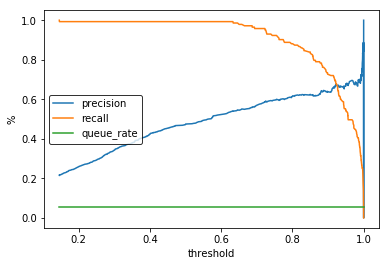

In [79]:
y_pred_probs = grid_lr.predict_proba(X_train)[:, 1]
plot_pr_curve(y_train, y_pred_probs)

In [80]:
for i in np.arange(0,0.5,0.05):
    y_pred = grid_lr.predict_proba(X_train)[:, 1] > i
    print("")
    print("Metrics")
    print("")
    print(confusion_metrics(y_train, y_pred))

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 0
False Negatives: 0
True Positives: 143
False Positives: 5277
 
Other Metrics:
 
Precision 0.03
Recall / True Positive Rate 1.00
True Negative Rate: 0.00
None

Metrics

True Negatives: 4152
False Negatives: 0
True Positives: 143
False Positives: 1125
 
Other Metrics:
 
Precision 0.11
Recall / True Positive Rate 1.00
True Negative Rate: 0.79
None

Metrics

True Negatives: 4593
False Negatives: 0
True Positives: 143
False Positives: 684
 
Other Metrics:
 
Precision 0.17
Recall / True Positive Rate 1.00
True Negative Rate: 0.87
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 4770
False Negatives: 1
True Positives: 142
False Positives: 507
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.99
True Negative Rate: 0.90
None

Metrics

True Negatives: 4869
False Negatives: 1
True Positives: 142
False Positives: 408
 
Other Metrics:
 
Precision 0.26
Recall / True Positive Rate 0.99
True Negative Rate: 0.92
None

Metrics

True Negatives: 4934
False Negatives: 1
True Positives: 142
False Positives: 343
 
Other Metrics:
 
Precision 0.29
Recall / True Positive Rate 0.99
True Negative Rate: 0.94
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics

True Negatives: 5005
False Negatives: 1
True Positives: 142
False Positives: 272
 
Other Metrics:
 
Precision 0.34
Recall / True Positive Rate 0.99
True Negative Rate: 0.95
None

Metrics

True Negatives: 5045
False Negatives: 1
True Positives: 142
False Positives: 232
 
Other Metrics:
 
Precision 0.38
Recall / True Positive Rate 0.99
True Negative Rate: 0.96
None

Metrics

True Negatives: 5084
False Negatives: 1
True Positives: 142
False Positives: 193
 
Other Metrics:
 
Precision 0.42
Recall / True Positive Rate 0.99
True Negative Rate: 0.96
None

Metrics

True Negatives: 5107
False Negatives: 1
True Positives: 142
False Positives: 170
 
Other Metrics:
 
Precision 0.46
Recall / True Positive Rate 0.99
True Negative Rate: 0.97
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


#### Feature Importances

In [110]:
one_hot_feature_names_lr = get_feature_names(grid_lr)

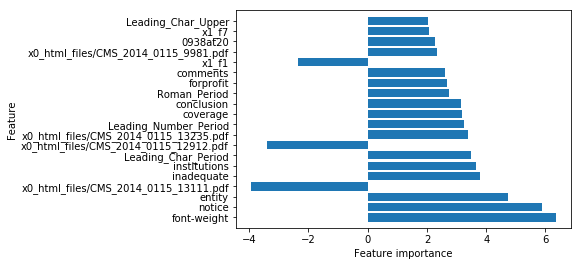

In [111]:
plot_top_k_feature_importances_pipe(one_hot_feature_names_lr, 
                                    grid_lr.best_estimator_.named_steps['classifier'].coef_[0], 
                                    20)

#### Test set

In [81]:
y_pred = grid_lr.predict(X_test)
confusion_metrics(y_test, y_pred)
metrics(y_test, y_pred)

True Negatives: 2196
False Negatives: 6
True Positives: 46
False Positives: 75
 
Other Metrics:
 
Precision 0.38
Recall / True Positive Rate 0.88
True Negative Rate: 0.97
Accuracy score: 0.97
F1 score: 0.53
ROC AUC score: 0.93


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


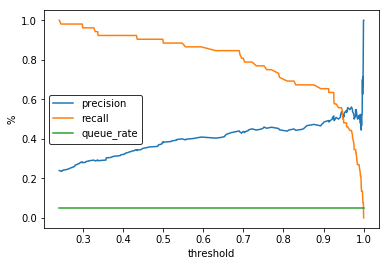

In [82]:
y_pred_probs = grid_lr.predict_proba(X_test)[:, 1]
plot_pr_curve(y_test, y_pred_probs)

In [83]:
for i in np.arange(0,0.5,0.01):
    y_pred = grid_rf.predict_proba(X_test)[:, 1] > i
    print("")
    print("Metrics")
    print("Threshold =", i)
    print("")
    print(metrics(y_test, y_pred))
    print(confusion_metrics(y_test, y_pred))

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.0

Accuracy score: 0.02
F1 score: 0.04
ROC AUC score: 0.50
None
True Negatives: 0
False Negatives: 0
True Positives: 52
False Positives: 2271
 
Other Metrics:
 
Precision 0.02
Recall / True Positive Rate 1.00
True Negative Rate: 0.00
None

Metrics
Threshold = 0.01

Accuracy score: 0.46
F1 score: 0.08
ROC AUC score: 0.72
None
True Negatives: 1019
False Negatives: 0
True Positives: 52
False Positives: 1252
 
Other Metrics:
 
Precision 0.04
Recall / True Positive Rate 1.00
True Negative Rate: 0.45
None

Metrics
Threshold = 0.02

Accuracy score: 0.64
F1 score: 0.11


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


ROC AUC score: 0.81
None
True Negatives: 1426
False Negatives: 0
True Positives: 52
False Positives: 845
 
Other Metrics:
 
Precision 0.06
Recall / True Positive Rate 1.00
True Negative Rate: 0.63
None

Metrics
Threshold = 0.03

Accuracy score: 0.74
F1 score: 0.15
ROC AUC score: 0.87
None
True Negatives: 1660
False Negatives: 0
True Positives: 52
False Positives: 611
 
Other Metrics:
 
Precision 0.08
Recall / True Positive Rate 1.00
True Negative Rate: 0.73
None

Metrics
Threshold = 0.04



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.80
F1 score: 0.18
ROC AUC score: 0.90
None
True Negatives: 1798
False Negatives: 0
True Positives: 52
False Positives: 473
 
Other Metrics:
 
Precision 0.10
Recall / True Positive Rate 1.00
True Negative Rate: 0.79
None

Metrics
Threshold = 0.05

Accuracy score: 0.84
F1 score: 0.22
ROC AUC score: 0.91
None
True Negatives: 1907
False Negatives: 1
True Positives: 51
False Positives: 364
 
Other Metrics:
 
Precision 0.12
Recall / True Positive Rate 0.98
True Negative Rate: 0.84
None

Metrics
Threshold = 0.06

Accuracy score: 0.87
F1 score: 0.25
ROC AUC score: 0.92
None
True Negatives: 1966
False Negatives: 1
True Positives: 51
False Positives: 305
 
Other Metrics:
 
Precision 0.14
Recall / True Positive Rate 0.98
True Negative Rate: 0.87
None

Metrics
Threshold = 0.07

Accuracy score: 0.89
F1 score: 0.29
ROC AUC score: 0.94
None
True Negatives: 2020
False Negatives: 1
True Positives: 51
False Positives: 251
 
Other Metrics:
 
Precision 0.17
Recall / True Positive Rate 0.

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.91
F1 score: 0.33
ROC AUC score: 0.94
None
True Negatives: 2062
False Negatives: 1
True Positives: 51
False Positives: 209
 
Other Metrics:
 
Precision 0.20
Recall / True Positive Rate 0.98
True Negative Rate: 0.91
None

Metrics
Threshold = 0.09

Accuracy score: 0.92
F1 score: 0.36
ROC AUC score: 0.94
None
True Negatives: 2097
False Negatives: 2
True Positives: 50
False Positives: 174
 
Other Metrics:
 
Precision 0.22
Recall / True Positive Rate 0.96
True Negative Rate: 0.92
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.1

Accuracy score: 0.94
F1 score: 0.40
ROC AUC score: 0.95
None
True Negatives: 2125
False Negatives: 2
True Positives: 50
False Positives: 146
 
Other Metrics:
 
Precision 0.26
Recall / True Positive Rate 0.96
True Negative Rate: 0.94
None

Metrics
Threshold = 0.11

Accuracy score: 0.95
F1 score: 0.46
ROC AUC score: 0.96
None
True Negatives: 2155
False Negatives: 2
True Positives: 50
False Positives: 116
 
Other Metrics:
 
Precision 0.30
Recall / True Positive Rate 0.96
True Negative Rate: 0.95
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.12

Accuracy score: 0.96
F1 score: 0.50
ROC AUC score: 0.96
None
True Negatives: 2173
False Negatives: 2
True Positives: 50
False Positives: 98
 
Other Metrics:
 
Precision 0.34
Recall / True Positive Rate 0.96
True Negative Rate: 0.96
None

Metrics
Threshold = 0.13

Accuracy score: 0.96
F1 score: 0.52
ROC AUC score: 0.96
None
True Negatives: 2181
False Negatives: 2
True Positives: 50
False Positives: 90
 
Other Metrics:
 
Precision 0.36
Recall / True Positive Rate 0.96
True Negative Rate: 0.96
None

Metrics
Threshold = 0.14

Accuracy score: 0.97
F1 score: 0.56
ROC AUC score: 0.96
None
True Negatives: 2195
False Negatives: 2
True Positives: 50
False Positives: 76
 
Other Metrics:
 
Precision 0.40
Recall / True Positive Rate 0.96
True Negative Rate: 0.97
None

Metrics
Threshold = 0.15

Accuracy score: 0.97
F1 score: 0.59
ROC AUC score: 0.96
None
True Negatives: 2206
False Negatives: 3
True Positives: 49
False Positives: 65
 
Other Metrics:
 
Precision 0.43
Recall 

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.16

Accuracy score: 0.97
F1 score: 0.61
ROC AUC score: 0.96
None
True Negatives: 2212
False Negatives: 3
True Positives: 49
False Positives: 59
 
Other Metrics:
 
Precision 0.45
Recall / True Positive Rate 0.94
True Negative Rate: 0.97
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.17

Accuracy score: 0.98
F1 score: 0.67
ROC AUC score: 0.96
None
True Negatives: 2226
False Negatives: 3
True Positives: 49
False Positives: 45
 
Other Metrics:
 
Precision 0.52
Recall / True Positive Rate 0.94
True Negative Rate: 0.98
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.18

Accuracy score: 0.98
F1 score: 0.70
ROC AUC score: 0.95
None
True Negatives: 2234
False Negatives: 4
True Positives: 48
False Positives: 37
 
Other Metrics:
 
Precision 0.56
Recall / True Positive Rate 0.92
True Negative Rate: 0.98
None

Metrics
Threshold = 0.19

Accuracy score: 0.98
F1 score: 0.72
ROC AUC score: 0.94
None
True Negatives: 2241
False Negatives: 6
True Positives: 46
False Positives: 30
 
Other Metrics:
 
Precision 0.61
Recall / True Positive Rate 0.88
True Negative Rate: 0.99
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.2

Accuracy score: 0.98
F1 score: 0.71
ROC AUC score: 0.93
None
True Negatives: 2242
False Negatives: 7
True Positives: 45
False Positives: 29
 
Other Metrics:
 
Precision 0.61
Recall / True Positive Rate 0.87
True Negative Rate: 0.99
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.21

Accuracy score: 0.99
F1 score: 0.73
ROC AUC score: 0.93
None
True Negatives: 2244
False Negatives: 7
True Positives: 45
False Positives: 27
 
Other Metrics:
 
Precision 0.62
Recall / True Positive Rate 0.87
True Negative Rate: 0.99
None

Metrics
Threshold = 0.22

Accuracy score: 0.99
F1 score: 0.73
ROC AUC score: 0.93
None
True Negatives: 2244
False Negatives: 7
True Positives: 45
False Positives: 27
 
Other Metrics:
 
Precision 0.62
Recall / True Positive Rate 0.87
True Negative Rate: 0.99
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.23

Accuracy score: 0.99
F1 score: 0.73
ROC AUC score: 0.92
None
True Negatives: 2246
False Negatives: 8
True Positives: 44
False Positives: 25
 
Other Metrics:
 
Precision 0.64
Recall / True Positive Rate 0.85
True Negative Rate: 0.99
None

Metrics
Threshold = 0.24

Accuracy score: 0.99
F1 score: 0.73
ROC AUC score: 0.92
None
True Negatives: 2247
False Negatives: 8
True Positives: 44
False Positives: 24
 
Other Metrics:
 
Precision 0.65
Recall / True Positive Rate 0.85
True Negative Rate: 0.99
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.25

Accuracy score: 0.99
F1 score: 0.75
ROC AUC score: 0.92
None
True Negatives: 2250
False Negatives: 8
True Positives: 44
False Positives: 21
 
Other Metrics:
 
Precision 0.68
Recall / True Positive Rate 0.85
True Negative Rate: 0.99
None

Metrics
Threshold = 0.26

Accuracy score: 0.99
F1 score: 0.75
ROC AUC score: 0.92
None
True Negatives: 2250
False Negatives: 8
True Positives: 44
False Positives: 21
 
Other Metrics:
 
Precision 0.68
Recall / True Positive Rate 0.85
True Negative Rate: 0.99
None

Metrics
Threshold = 0.27



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.99
F1 score: 0.75
ROC AUC score: 0.91
None
True Negatives: 2251
False Negatives: 9
True Positives: 43
False Positives: 20
 
Other Metrics:
 
Precision 0.68
Recall / True Positive Rate 0.83
True Negative Rate: 0.99
None

Metrics
Threshold = 0.28

Accuracy score: 0.99
F1 score: 0.76
ROC AUC score: 0.91
None
True Negatives: 2253
False Negatives: 9
True Positives: 43
False Positives: 18
 
Other Metrics:
 
Precision 0.70
Recall / True Positive Rate 0.83
True Negative Rate: 0.99
None

Metrics
Threshold = 0.29



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.99
F1 score: 0.77
ROC AUC score: 0.91
None
True Negatives: 2254
False Negatives: 9
True Positives: 43
False Positives: 17
 
Other Metrics:
 
Precision 0.72
Recall / True Positive Rate 0.83
True Negative Rate: 0.99
None

Metrics
Threshold = 0.3

Accuracy score: 0.99
F1 score: 0.75
ROC AUC score: 0.89
None
True Negatives: 2254
False Negatives: 11
True Positives: 41
False Positives: 17
 
Other Metrics:
 
Precision 0.71
Recall / True Positive Rate 0.79
True Negative Rate: 0.99
None

Metrics
Threshold = 0.31



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.99
F1 score: 0.77
ROC AUC score: 0.89
None
True Negatives: 2257
False Negatives: 11
True Positives: 41
False Positives: 14
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.79
True Negative Rate: 0.99
None

Metrics
Threshold = 0.32

Accuracy score: 0.99
F1 score: 0.71
ROC AUC score: 0.84
None
True Negatives: 2257
False Negatives: 16
True Positives: 36
False Positives: 14
 
Other Metrics:
 
Precision 0.72
Recall / True Positive Rate 0.69
True Negative Rate: 0.99
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.33

Accuracy score: 0.99
F1 score: 0.71
ROC AUC score: 0.84
None
True Negatives: 2258
False Negatives: 16
True Positives: 36
False Positives: 13
 
Other Metrics:
 
Precision 0.73
Recall / True Positive Rate 0.69
True Negative Rate: 0.99
None

Metrics
Threshold = 0.34

Accuracy score: 0.99
F1 score: 0.69
ROC AUC score: 0.82
None
True Negatives: 2259
False Negatives: 18
True Positives: 34
False Positives: 12
 
Other Metrics:
 
Precision 0.74
Recall / True Positive Rate 0.65
True Negative Rate: 0.99
None

Metrics
Threshold = 0.35000000000000003



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.99
F1 score: 0.68
ROC AUC score: 0.81
None
True Negatives: 2259
False Negatives: 19
True Positives: 33
False Positives: 12
 
Other Metrics:
 
Precision 0.73
Recall / True Positive Rate 0.63
True Negative Rate: 0.99
None

Metrics
Threshold = 0.36

Accuracy score: 0.99
F1 score: 0.67
ROC AUC score: 0.81
None
True Negatives: 2260
False Negatives: 20
True Positives: 32
False Positives: 11
 
Other Metrics:
 
Precision 0.74
Recall / True Positive Rate 0.62
True Negative Rate: 1.00
None

Metrics
Threshold = 0.37

Accuracy score: 0.99
F1 score: 0.68
ROC AUC score: 0.81
None
True Negatives: 2261
False Negatives: 20
True Positives: 32
False Positives: 10
 
Other Metrics:
 
Precision 0.76
Recall / True Positive Rate 0.62
True Negative Rate: 1.00
None

Metrics
Threshold = 0.38

Accuracy score: 0.99
F1 score: 0.67
ROC AUC score: 0.80
None
True Negatives: 2261
False Negatives: 21
True Positives: 31
False Positives: 10
 
Other Metrics:
 
Precision 0.76
Recall / True Positive Rate 0.

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 2261
False Negatives: 23
True Positives: 29
False Positives: 10
 
Other Metrics:
 
Precision 0.74
Recall / True Positive Rate 0.56
True Negative Rate: 1.00
None

Metrics
Threshold = 0.4

Accuracy score: 0.99
F1 score: 0.62
ROC AUC score: 0.77
None
True Negatives: 2261
False Negatives: 24
True Positives: 28
False Positives: 10
 
Other Metrics:
 
Precision 0.74
Recall / True Positive Rate 0.54
True Negative Rate: 1.00
None

Metrics
Threshold = 0.41000000000000003

Accuracy score: 0.98
F1 score: 0.59
ROC AUC score: 0.75
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


True Negatives: 2261
False Negatives: 26
True Positives: 26
False Positives: 10
 
Other Metrics:
 
Precision 0.72
Recall / True Positive Rate 0.50
True Negative Rate: 1.00
None

Metrics
Threshold = 0.42

Accuracy score: 0.98
F1 score: 0.57
ROC AUC score: 0.73
None
True Negatives: 2263
False Negatives: 28
True Positives: 24
False Positives: 8
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.46
True Negative Rate: 1.00
None

Metrics
Threshold = 0.43

Accuracy score: 0.98
F1 score: 0.57
ROC AUC score: 0.73
None
True Negatives: 2263
False Negatives: 28
True Positives: 24
False Positives: 8
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.46
True Negative Rate: 1.00
None


/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)



Metrics
Threshold = 0.44

Accuracy score: 0.98
F1 score: 0.57
ROC AUC score: 0.73
None
True Negatives: 2263
False Negatives: 28
True Positives: 24
False Positives: 8
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.46
True Negative Rate: 1.00
None

Metrics
Threshold = 0.45

Accuracy score: 0.98
F1 score: 0.57
ROC AUC score: 0.73
None
True Negatives: 2263
False Negatives: 28
True Positives: 24
False Positives: 8
 
Other Metrics:
 
Precision 0.75
Recall / True Positive Rate 0.46
True Negative Rate: 1.00
None

Metrics
Threshold = 0.46



/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.71
None
True Negatives: 2265
False Negatives: 30
True Positives: 22
False Positives: 6
 
Other Metrics:
 
Precision 0.79
Recall / True Positive Rate 0.42
True Negative Rate: 1.00
None

Metrics
Threshold = 0.47000000000000003

Accuracy score: 0.98
F1 score: 0.55
ROC AUC score: 0.70
None
True Negatives: 2267
False Negatives: 31
True Positives: 21
False Positives: 4
 
Other Metrics:
 
Precision 0.84
Recall / True Positive Rate 0.40
True Negative Rate: 1.00
None

Metrics
Threshold = 0.48

Accuracy score: 0.98
F1 score: 0.49
ROC AUC score: 0.67
None
True Negatives: 2268
False Negatives: 34
True Positives: 18
False Positives: 3
 
Other Metrics:
 
Precision 0.86
Recall / True Positive Rate 0.35
True Negative Rate: 1.00
None

Metrics
Threshold = 0.49

Accuracy score: 0.98
F1 score: 0.47
ROC AUC score: 0.66
None
True Negatives: 2268
False Negatives: 35
True Positives: 17
False Positives: 3
 
Other Metrics:
 
Precision 0.85
Recall / True Posit

/Users/pranjalbajaj/anaconda3/envs/kpmgcapstone/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### Precision - Recall Curve

Average precision-recall score RF: 0.5256189284456264


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.53')

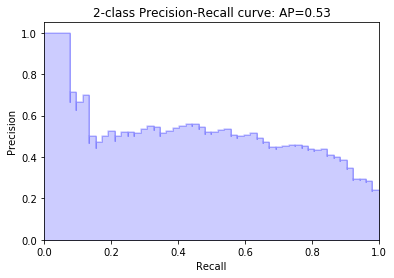

In [84]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


average_precision = average_precision_score(y_test, y_pred_probs)

print('Average precision-recall score RF: {}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
